<a href="https://colab.research.google.com/github/george-kan/fastai/blob/main/Chapter13/Chapter_13_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade fastai
from fastai.vision.all import *
from fastai import *

In [2]:
matplotlib.rc('image', cmap='Greys')

In [3]:
top_edge = tensor([[-1,-1,-1],
                  [0,0,0],
                  [1,1,1]]).float()

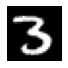

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3, cmap = 'gray')

In [5]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[:10, :20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


For the top edge of the 3, we have the values above the middle row being 0 (so no contribution) and the values on the bottom row being high positive numbers so overall we get a high positive number from the multiplication.
For the bottom edge, the opposite is true.

In [6]:
(im3_t[4:7, 6:9]*top_edge).sum()

tensor(762.)

In [7]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2, col-1:col+2]*kernel).sum()

In [8]:
apply_kernel(5, 7, top_edge)

tensor(762.)

In [9]:
??show_image

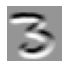

In [10]:
top_edge3 = tensor([[apply_kernel(row, col, top_edge) for col in range(1,27)] for row in range(1,27)])
show_image(top_edge3)

In [11]:
left_edge = tensor([[-1, 0, 1],
                    [-1,0,1],
                    [-1,0,1]])

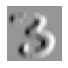

In [12]:
left_edge3 = tensor([[apply_kernel(row, col, left_edge) for col in range(1,27)] for row in range(1,27)])
show_image(left_edge3)

In [13]:
diag1_edge = tensor([[0,-1,1],
                     [-1,1,0],
                     [1,0,0]])
# This diag edge finds only the diag edges without anything above them. 
# See the picture below, there is a white diag edge below the black one

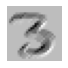

In [14]:
diag1 = tensor([[apply_kernel(row, col, diag1_edge) for col in range(1,27)] for row in range(1,27)])
show_image(diag1)

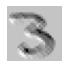

In [15]:
diag2_edge = tensor([[1,-1,0],
                     [0,1,-1],
                     [0,0,1]])
diag2 = tensor([[apply_kernel(row, col, diag2_edge) for col in range(1,27)] for row in range(1,27)])
show_image(diag2)

In [16]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [17]:
mnist = DataBlock((ImageBlock(cls = PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter = GrandparentSplitter(),
                  get_y = parent_label)
dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [18]:
xb, yb = to_cpu(xb), to_cpu(yb)

In [19]:
edge_kernels = edge_kernels.unsqueeze(1)
edge_kernels.shape
# We need to add an extra dimension here because torch expects a 4 dimensional tensor

torch.Size([4, 1, 3, 3])

In [20]:
xb.shape

torch.Size([64, 1, 28, 28])

In [21]:
??F.conv2d

In [22]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

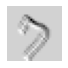

In [23]:
show_image(batch_features[0,3])
# First image example, 4th convolution (diag2)

In [24]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [25]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1,30, kernel_size=3, padding = 1), #1 is the input and 30 is the output channels
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1)
)
# The input to the convolution is n, 1 (we have black-white images), 28, 28
# The output of the first convolution is n, 30, 28, 28 --> A different kernel is applied to the original image 30 times
# The output of the final convolution is n, 1, 28, 28 --> One kernel is applied to all the "images" and the output is summed up to 1
# For example the pixel 1,1 is the output of the same one kernel applied to the first 3x3 pixels of all 30 of the input channels and then summed up



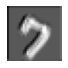

In [26]:
show_image(broken_cnn(xb)[0,0])

In [27]:
my_broken_cnn = nn.Sequential(
    nn.Conv2d(1,30, kernel_size=3, padding = 1))

my_broken_cnn(xb).shape


torch.Size([64, 30, 28, 28])

In [28]:
my_broken_cnn(xb)[0, 1].shape

torch.Size([28, 28])

In [29]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [30]:
simple_cnn = sequential(
    conv(1,4), #14x14
    conv(4,8), #7x7
    conv(8,16), #4x4
    conv(16, 32), #2x2
    conv(32, 2, act=False),
    Flatten()
)

In [31]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [32]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                                        

In [33]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.064139,0.041274,0.986752,00:12
1,0.017858,0.017192,0.994112,00:11


In [34]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(full=False)
)

In [35]:
m = learn.model
m[0][0].weight.shape, m[0][0].bias.shape, m[1][0].weight.shape, m[1][0].bias.shape
# For each layer the weights are OutChannels x InpChannels x Kernel_size

(torch.Size([4, 1, 3, 3]),
 torch.Size([4]),
 torch.Size([8, 4, 3, 3]),
 torch.Size([8]))

Convolution notes
Layer 1  
Input 1x28x28  
Conv2d(1, 4, ks = 3, pad = 1, stride = 2)  
--> Weights: 4x1x3x3  
Why? We have 4 output channels. Therefore, we need 4 of our kernels for each of our input channels (1). Each kernel is 3x3.  
--> Multiplications: 1x4x3x3x28x28  
Why? We need to multiply each of our input channels (1) by each of our kernels (4x3x3) for every pixel (28x28).  

Layer 2
Input 4x14x14  
Conv2d(4, 8, ks = 3, pad = 1, stride = 2)  
--> Weights: 8x4x3x3  
Why? We have 8 output channels. Therefore, we need 8 of our kernels for each of our input channels (4). Each kernel is 3x3.  
--> Multiplications: 4x8x3x3x14x14  
Why? We need to multiply each of our input channels (4) by each of our kernels (8x3x3) for every pixel (14x14).  


In [36]:
path = untar_data(URLs.MNIST)

In [41]:
(path/'training').ls()

(#10) [Path('/root/.fastai/data/mnist_png/training/2'),Path('/root/.fastai/data/mnist_png/training/6'),Path('/root/.fastai/data/mnist_png/training/1'),Path('/root/.fastai/data/mnist_png/training/9'),Path('/root/.fastai/data/mnist_png/training/7'),Path('/root/.fastai/data/mnist_png/training/5'),Path('/root/.fastai/data/mnist_png/training/3'),Path('/root/.fastai/data/mnist_png/training/4'),Path('/root/.fastai/data/mnist_png/training/8'),Path('/root/.fastai/data/mnist_png/training/0')]

In [37]:
def get_dls(bs = 64):
    return DataBlock(blocks = (ImageBlock(cls=PILImageBW), CategoryBlock),
              get_items = get_image_files,
              splitter = GrandparentSplitter('training', 'testing'),
              get_y = parent_label,
              batch_tfms = Normalize()).dataloaders(path, bs = bs)

In [38]:
dls = get_dls()

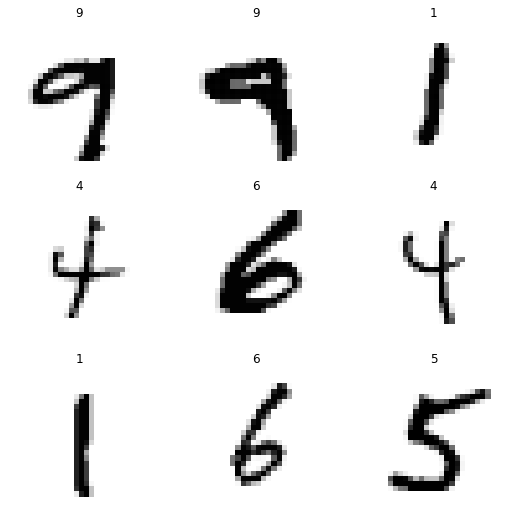

In [39]:
dls.show_batch()

In [42]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )
# Why did we make the network bigger?
# This time we have to "learn" more numbers, so at first we increase the number of filters
# Why do we increase the ks at the first layer?
# Before we had a ks=3 for 4 filters. This meant that from 3x3=9 pixels we were learning 4 stuff. 
# But with a ks=3 for 8 filters we are not learning anything. The NN will simply copy the pixels
# Therefore we have a ks=5 to force the NN to learn from 5*5=25 pixels 8 stuff.
# Why only for the first layer?

Let's analyse the above comments in more detail:  
Before we had 1, 4, 3, 3 => This meant we have 1 input layer (constant before and currently), 4 channel outputs and a kernel of size 3x3 applied on the input.  
This meant that we had essentially 4 3x3 kernels applied to our input, each one of them returning 1 value from every 9 input values (pixels).   

In the new configuration we would have 1, 8, 3, 3
This meant that we have 8 3x3 kernels applied to our input and each one of them returning 1 value from every 9 input values (pixels).

??? I am not sure why is that neccessarily bad. It is true that we are deriving 8 values from 9 input values but I don't undestand why the NN will not learn anything...

### Apparently in order for the network to learn it needs to condense information...




In [43]:
from fastai.callback.hook import *

In [44]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.305551,2.303992,0.100900,01:01


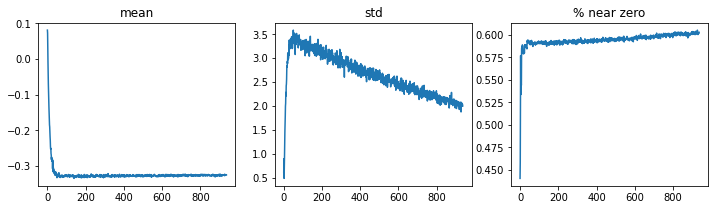

In [45]:
learn.activation_stats.plot_layer_stats(0)

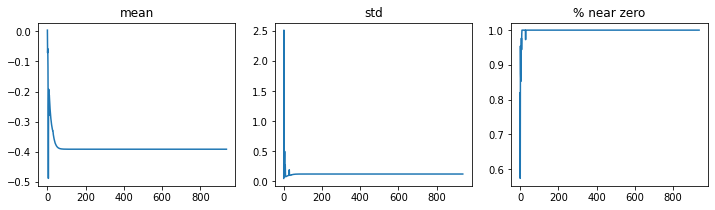

In [46]:
learn.activation_stats.plot_layer_stats(-2)

In [47]:
# The activations that are close to 0 is almost 100% in the end and therefore 
#the NN fails to train correctly

In [48]:
dls = get_dls(512)
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.339775,2.303016,0.102800,00:51


In [49]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.206133,0.072099,0.976800,00:51


In [52]:
??learn.fit_one_cycle

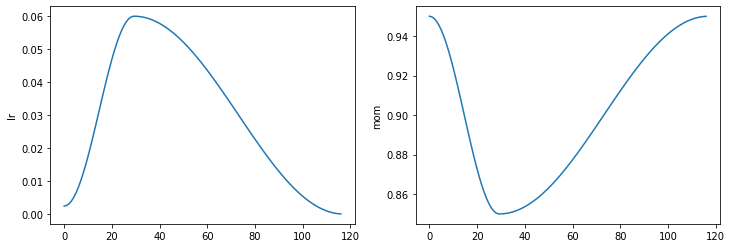

In [53]:
learn.recorder.plot_sched()

In [54]:
??learn.recorder.plot_sched()

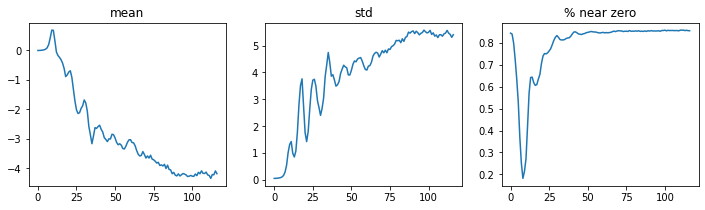

In [55]:
learn.activation_stats.plot_layer_stats(-2)

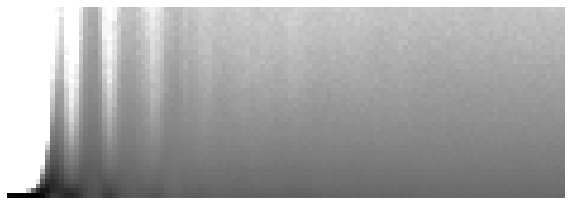

In [56]:
learn.activation_stats.color_dim(-2)

In [57]:
def conv(ni, nf, ks=3, act = True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf))
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [58]:
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.132217,0.056823,0.986300,00:54
